# Numerical code generation from symbolic expressions in Python

### Fabio Rossi

### email: fabio.rossi@inaf.it

### Github: https://github.com/FabioRossiArcetri

#### “Astrobigné” presentation, Arcetri 06/10/2020

# Introduction

- Numpy/SciPy  are widely used in numerical codes, at different scales
- NumPy can be seen as an implementation on the CPU of the “Array Programming” paradigm:
    - https://www.nature.com/articles/s41586-020-2649-2#article-info
- Other implementations of the same paradigm have been developed (similar APIs, different backend) :
    - CuPy, GPU, based on NVIDIA CUDA
    - ClPy, GPU/CPU based on openCL
- Tensorflow (GPU/CPU mainly used for Neural Networks development)

# Motivation
- What happens when you have to develop a numerical code?
    - Somewhere the math of the problem is stated, a bunch of expressions, functions, integrals, matrices etc
    - During the implementation phase, the needed math is embedded in the code in more or less clean/modular fashion
- Are the algorithms well apart from the mathematical definitions?
- How reusable is you code?
- Can you easily use the same expression in different algorithms?
- Could run your code (or just its critical parts) on a GPU? How easily could you port it to use some library that allows it?

# Motivation

- Usually numerical codes are developed independently from symbolic functions definition
- SymPy is the Python library implementing symbolic computation
    - it is a CAS, Computer Algebra System like Mathematica, MathCad, Maple, but developed in Python and OpenSource
- Can we benefit by introducing symbolic expression definition and manipulation Numerical Code development cycle?
    - One more step
    - Symbolic functions can be manipulated in ways numerical functions can’t
    - Sympy Symbolic functions can be translated automatically to numerical functions

# Approach and Architecture

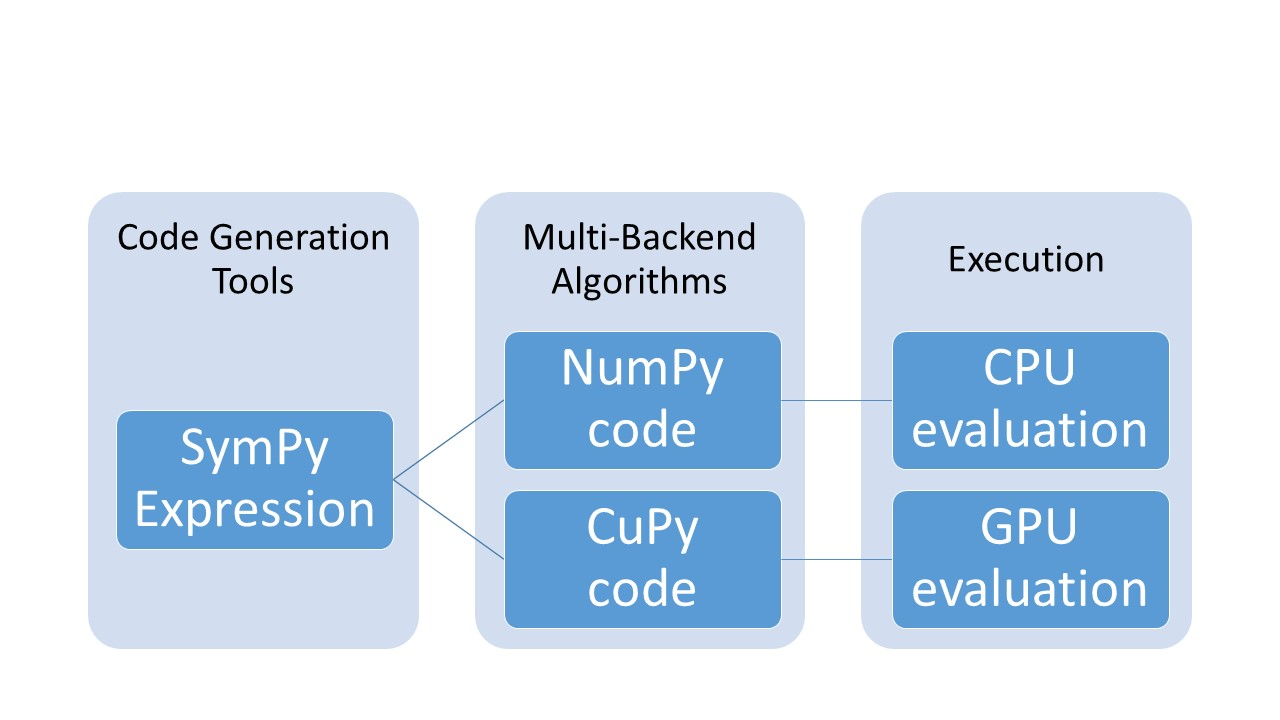

In [4]:
from IPython.display import Image
Image(filename='Astrobigne2020.jpg',width=800, height=400)

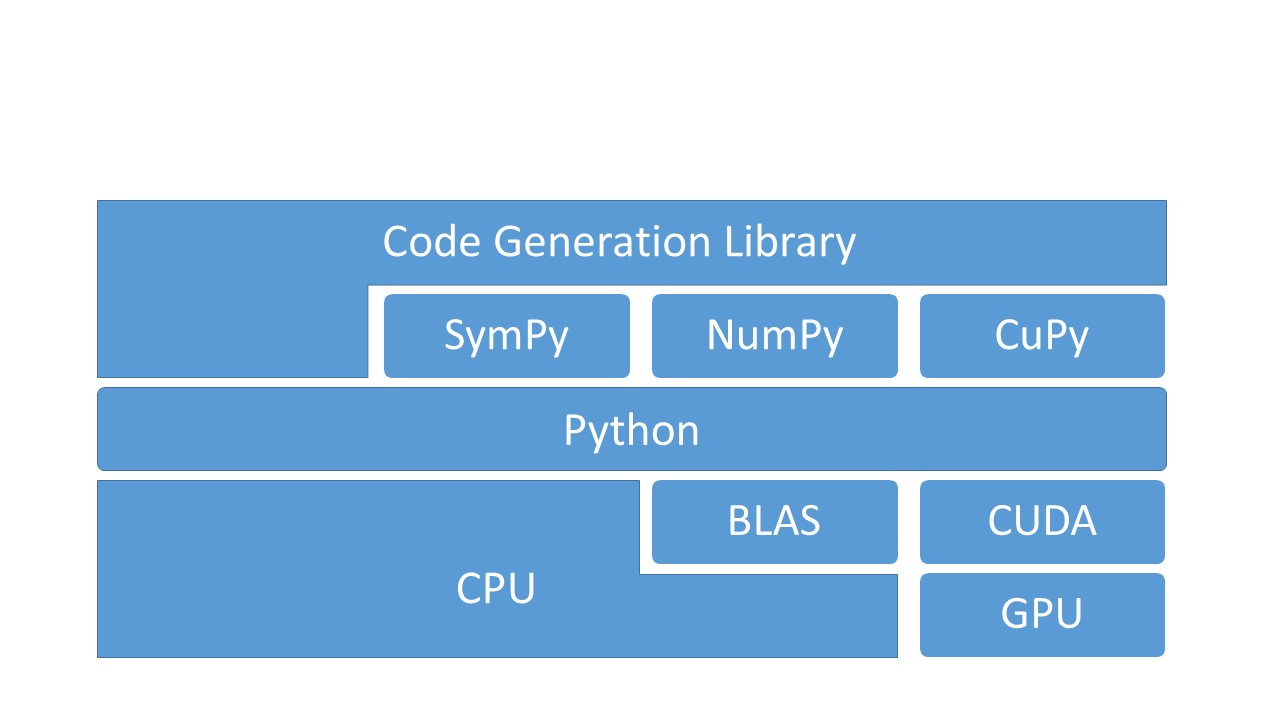

In [5]:
Image(filename='Astrobigne2020_2.jpg',width=800, height=400)

# Sympy basics

- Define some symbols
- Define a function
- .. or an integral
- Specialize
- Evaluate

In [6]:
import sympy as sp

#Define some symbols
x, y, a, b = sp.symbols("x y a b")
# Define a function
f1 = sp.exp(-a*x**2-b*y**2)
# see how nicely it is displayed
display(f1)

exp(-a*x**2 - b*y**2)

In [7]:
# Or define an integral
i1 = sp.Integral(f1, (x,-sp.oo,+sp.oo), (y,-sp.oo,+sp.oo))
display(i1)

Integral(exp(-a*x**2 - b*y**2), (x, -oo, oo), (y, -oo, oo))

In [8]:
# Specialize
i2 = i1.subs([(a, 1), (b,2)])
# Evaluate
display(i2.doit())

sqrt(2)*pi/2

In [9]:
#You could also do real symbolic computations… : 
fdev = sp.diff(f1, y) 
display(fdev)

-2*b*y*exp(-a*x**2 - b*y**2)

# lambdas and ufuncs

- A lambda is just a (usually small) anonymous function:

In [10]:
f = lambda a,b,c : a+b*c
print(f(5, 6, 2))

17


In [11]:
# also useful when you want to do have a function that returns a function:
def myfunc(n):
    return lambda a:a*n

mydoubler = myfunc(2)
print(mydoubler(11))

22


In [12]:
a

a

- A (basic) ufunc in NumPy (or CuPy) is a function that can be applied to vectors, working an element-wise basis. 
    - for example: np.sin, np.cos, np.power
    - np.meshgrid() is not!
    - np.sum() is a reduction ufunc...
    - details here: https://numpy.org/doc/stable/reference/ufuncs.html

# Array programming

- do as much as possible using Numpy built-in functions and avoid loops and element-wise access
- Performances: Python-like vs C-like !
- Transition to different backends (i.e. CuPy)
- Even more crucial for performances on the GPU

In [13]:
import numpy as np

def mySquaredSum(xx):
    r = 0.0
    for i in range(xx.shape[0]):
        r += xx[i]*xx[i]
    return r

npoints = int(1e5)

x = np.linspace(1, 100000, npoints)
print(mySquaredSum(x))

333338333350000.0


In [14]:
%%timeit
y = mySquaredSum(x)

47.4 ms ± 710 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
f = lambda x: np.sum(np.square(x))
print(f(x))

333338333350000.0


In [16]:
%%timeit
y = f(x)

97.4 µs ± 16.8 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# More than 400 times faster !

# Array programming on the GPU with CuPy

- CuPy API tries to be as similar as possible to NumPy's, https://docs.cupy.dev/en/stable/
- Comparison table of the two libraries: https://docs.cupy.dev/en/stable/reference/comparison.html
- Important issue to take care of: CPU<->GPU data transfer
    - if the data set you are performing your computation on is quite small, depending on how complex is your computations, it might get less efficient to transfer it to the GPU and get the result back than simply perform your computation on the CPU

In [17]:
import numpy as np
import cupy as cp

npoints = int(1e6)
fcpu = lambda x : np.sum( np.sin(x) * np.exp(x) / (1+np.sqrt(np.abs(x)) ) ) / npoints
x_cpu = np.linspace(-1.0, 1.0, npoints)
print(fcpu(x_cpu))

0.17955110645016475


In [18]:
%%timeit
fcpu(x_cpu)

44.8 ms ± 13.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
x_gpu = cp.linspace(-1.0, 1.0, npoints)
fgpu = lambda x : cp.sum( cp.sin(x) * cp.exp(x) / (1+cp.sqrt(cp.abs(x)) ) ) / npoints
result = fgpu(x_gpu)
print(type(result), result)

<class 'cupy.core.core.ndarray'> 0.1795511064501647


In [20]:
%%timeit
fgpu(x_gpu)

1.41 ms ± 2.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# 30 times faster !

- moving data from the CPU to the GPU

In [21]:
x_cpu = np.array([1,2,3])
print(type(x_cpu), x_cpu)
x_gpu = cp.asarray(x_cpu)  # move the data to the current device.
print(type(x_gpu), x_gpu)

<class 'numpy.ndarray'> [1 2 3]
<class 'cupy.core.core.ndarray'> [1 2 3]


-  moving data from the GPU to the CPU

In [22]:
x_gpu = cp.array([1, 2, 3])  # create an array in the current device
print(type(x_gpu), x_gpu)
x_cpu = cp.asnumpy(x_gpu)  # move the array to the host.
print(type(x_cpu), x_cpu)

<class 'cupy.core.core.ndarray'> [1 2 3]
<class 'numpy.ndarray'> [1 2 3]


# Sympy Lambdify

- Sympy provides the lambdify method to transform a sympy expression to a lambda, for different backends ("math", "mpmath", "numpy", "numexpr", "scipy")
- What about a CuPy lambda? 
- We can pass to lambdify a dictionary which maps sympy functions to cupy functions
- The dictionary will include many obvious translations ... 
    - gpulib = { ... 'sin': cp.sin … 

In [23]:
import sympy as sp
import inspect

from seeing import *

x = sp.symbols('x')
fsympy = sp.sin(x) * sp.exp(x) / (1+sp.sqrt(sp.Abs(x)) ) 
display(fsympy)
fnumpy = sp.lambdify(x, fsympy, "numpy" )
print(inspect.getsource(fnumpy))
print(fnumpy.__globals__['sin'])

fcupy = sp.lambdify(x, fsympy, gpulib )
print(inspect.getsource(fcupy))
print(fcupy.__globals__['sin'])

exp(x)*sin(x)/(sqrt(Abs(x)) + 1)

def _lambdifygenerated(x):
    return (exp(x)*sin(x)/(sqrt(abs(x)) + 1))

<ufunc 'sin'>
def _lambdifygenerated(x):
    return (exp(x)*sin(x)/(sqrt(abs(x)) + 1))

<ufunc 'cupy_sin'>


# A few problems

- What about SymPy functions which do not have a CuPy analogue?
    - i.e. CuPy only provides the Bessel Functions of the first order of index 0 and 1... but we can implent our own version for general n!

In [24]:
def besselj__n(n, z):
    if n==0:
        return cupyx.scipy.special.j0(z)
    elif n==1:
        return cupyx.scipy.special.j1(z)
    elif n>=2:
        return 2*besselj__n(n-1, z)/z - besselj__n(int(n)-2, z)

# in gpulib we will have, at some point ... 'besselj: 'besselj__n' ... 

n = sp.symbols('n', integer=True)
fsympy = sp.besselj(n, x)
display(fsympy)
fnumpy = sp.lambdify((x, n), fsympy, "scipy" )
print(inspect.getsource(fnumpy))
print(fnumpy.__globals__['jv'])

fcupy = sp.lambdify((x,n), fsympy, gpulib )
print(inspect.getsource(fcupy))
print(fcupy.__globals__['besselj'])

besselj(n, x)

def _lambdifygenerated(x, n):
    return (jv(n, x))

<ufunc 'jv'>
def _lambdifygenerated(x, n):
    return (besselj(n, x))

<function besselj__n at 0x7f829c682840>


- When manipulating an expression imported from another module, we would like an easy way to access its symbols, symbols' names

In [25]:
# lets say we have this function returning a SymPy expression defined somewhere
def niceExpr():
    x0, y0, ss = sp.symbols('x_0 y_0 sigma')
    return sp.exp(-x0/ss) + sp.log(1+sp.Abs(y0)*ss)

# then in out main program we could have:
anExpr=niceExpr()
display(anExpr)

log(sigma*Abs(y_0) + 1) + exp(-x_0/sigma)

- just looking at the expression, we can tell there is a parameter named sigma
- we would like to substitute it with some specific real value, how to do it?
- we do not have easy acces to the 'ss' variable!!!

In [26]:
print(anExpr.free_symbols)
# cannot do this: ss = anExpr.free_symbols[1]

# we can do this:
ss = sp.symbols('sigma')
anExprSpec = anExpr.subs(ss, 0.5)
display(anExprSpec)

# ugly, what if sigma was complex?

{sigma, y_0, x_0}


log(0.5*Abs(y_0) + 1) + exp(-2.0*x_0)

- We want to have group of formulas sharing the same symbols, this is not obviosly done in SymPy
- We want to implement numerical algorithms that can have in input SymPy expressions and run relying on NumPy or CuPy (same algorithm AND code, different backend)
    - Think about a Monte Carlo integration method that can work using calls like:
        - sp.lambdify(integrand_functions, xp), xp.sum(), xp.random.unifor() etc etc, where xp is a variable point to either np or cp

# SEEING: Sympy Expressions Evaluation Implemented oN the GPU

- Factor out common tasks when using SymPy expressions as a starting point of your numerical code
- Helper functions to handle a group of SymPy expressions
    - evaluate, plot, substitute parameters, share variables
- A simple way to generate NumPy of CuPy code, so that you quickly evaluate expressions on the GPU
- Backend agnostic Numerical Algorithms
    - lots of xp.something calls!
    - currently numpy and cupy are supported, in the future clpy or other numerical backends might be added
    - for now just a few Numerical Integration methods, over n-dimensional domains

# SEEING Overview

- Define a sympy function
- Specialize some parameters
- Evaluate an integral on the CPU or on the GPU

In [27]:
from seeing import *



# Real-life example using SEEING

- We are using the approach described so far and the SEEING library to develop simulations related to the development of the MAVIS instrument for the VLT telescope
- Quite a few expressions:

# This is interesting, now what?
- Refresh your NumPy skills (ufuncs, array programming)
    - for loops are evil !!!
- Start using SymPy: don’t need to become an expert, just need to able to define your expressions/functions
- Understand basic concepts of GPU programming by experimenting with CuPy: if you know NumPy it’s going to be almost straightforward
- “SEEING” library could help you to easily manipulate/lambdify/evaluate your math on CPU/GPU
- # Be relieved! You don’t need to learn C/C++ and CUDA if you don't want to!